In [10]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
# !pip install -U albumentations>=0.3.0 --user 
# !pip install -U --pre segmentation-models --user

  Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl (19 kB)


In [3]:
!pip install split_folders 

# Loading dataset

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [77]:
fldr = r"C:\Users\Lab311\Projects\bengio"
files = [f"{fldr}\\{t}" for t in os.listdir(fldr) if "npz" in t]
X_data = list()
y_data = list()

for _filename in files:
    with np.load(_filename) as d:
        X_data.append(d['x'].astype(np.uint8))
        y_data.append(d['y'].astype(np.uint8))
X_data = np.stack(X_data)
y_data = np.stack(y_data)

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print(f"Train X_size: {X_train.shape}")
print(f"Validation X_size: {X_val.shape}")
print(f"Train X_size: {y_train.shape}")
print(f"Validation y_size: {y_train.shape}")

Train size: (3200, 128, 128, 3)
Validation size: (800, 128, 128, 3)
Test size: (3200, 128, 128, 18)
y_train shape: (3200, 128, 128, 18)


In [91]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=42)
print(f"Train X_size: {X_val.shape}")
print(f"Test X_size: {X_test.shape}")
print(f"Train X_size: {y_val.shape}")
print(f"Test y_size: {y_test.shape}")

Train X_size: (640, 128, 128, 3)
Test X_size: (160, 128, 128, 3)
Train X_size: (640, 128, 128, 18)
Test y_size: (160, 128, 128, 18)


# Dataloader and utility functions 

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(32, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
def image_denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

class Dataset:
    CLASSES = [
        'skin', 
        'nose',
        'background',
        'l_eye',
        'r_eye',
        'l_brow',
        'r_brow',
        'l_ear',
        'r_ear',
        'eye_g',
        'u_lip',
        'l_lip',
        'hair',
        'hat',
        'ear_r',
        'mouth',
        'neck_l',
        'neck', 
        'cloth',
    ]
    
    def __init__(
            self, 
            images,
            masks, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images = images
        self.masks = masks

        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        

        image = self.images[i]
        mask = self.masks[i]
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            mask = mask.astype('float32')
            
        return image, mask
        
    def __len__(self):
        return len(self.images)
    
    
class Dataloder(keras.utils.Sequence):
  
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

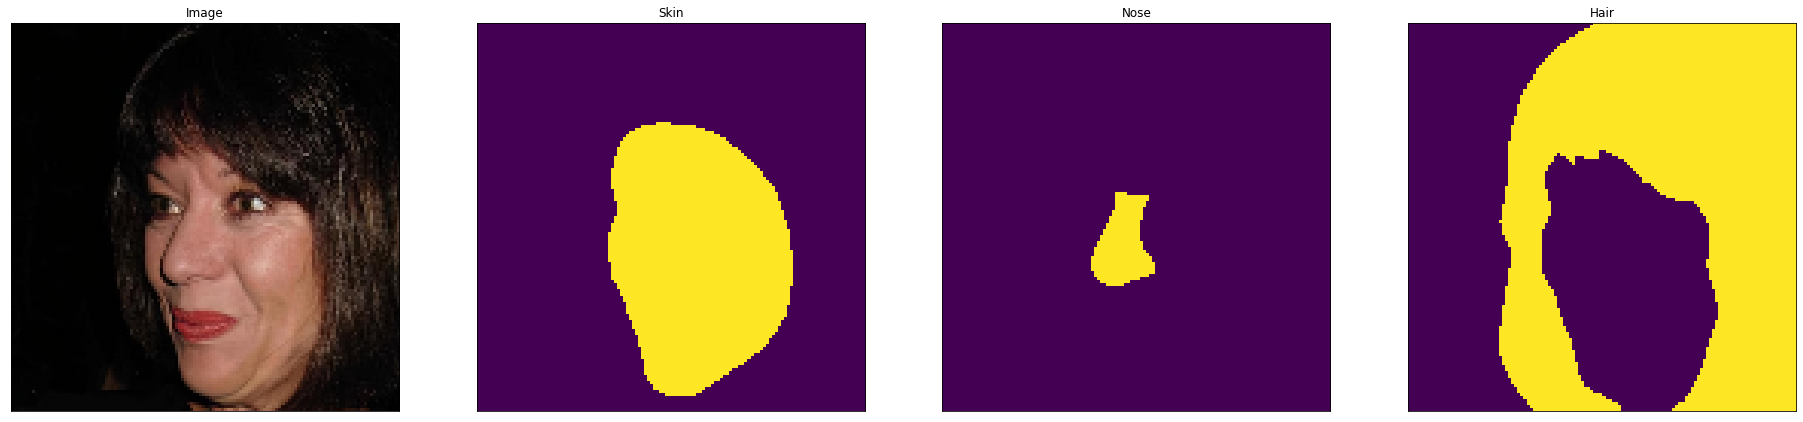

In [9]:
classes = [
        'skin', 
        'nose',
        'background',
        'l_eye',
        'r_eye',
        'l_brow',
        'r_brow',
        'l_ear',
        'r_ear',
        'eye_g',
        'u_lip',
        'l_lip',
        'hair',
        'hat',
        'ear_r',
        'mouth',
        'neck_l',
        'neck', 
        'cloth',
]
dataset = Dataset(X_train, y_train, classes=classes)

image, mask = dataset[5]
visualize(
    image=image, 
    skin=mask[:, :, 0],
    nose=mask[:, :, 1],
    hair=mask[:, :, 12],
)

## Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops


In [12]:
import albumentations as A

In [13]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation(img_size):
    H, W = img_size
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=H, min_width=W, always_apply=True, border_mode=0),
        A.RandomCrop(height=H, width=W, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

C:\Users\Lab311\AppData\Roaming\Python\Python37\site-packages\albumentations\imgaug\transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
C:\Users\Lab311\AppData\Roaming\Python\Python37\site-packages\albumentations\imgaug\transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
C:\Users\Lab311\AppData\Roaming\Python\Python37\site-packages\albumentations\augmentations\transforms.py:1151: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
C:\Users\Lab311\AppData\Roaming\Python\Python37\site-packages\albumentations\imgaug\transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated.

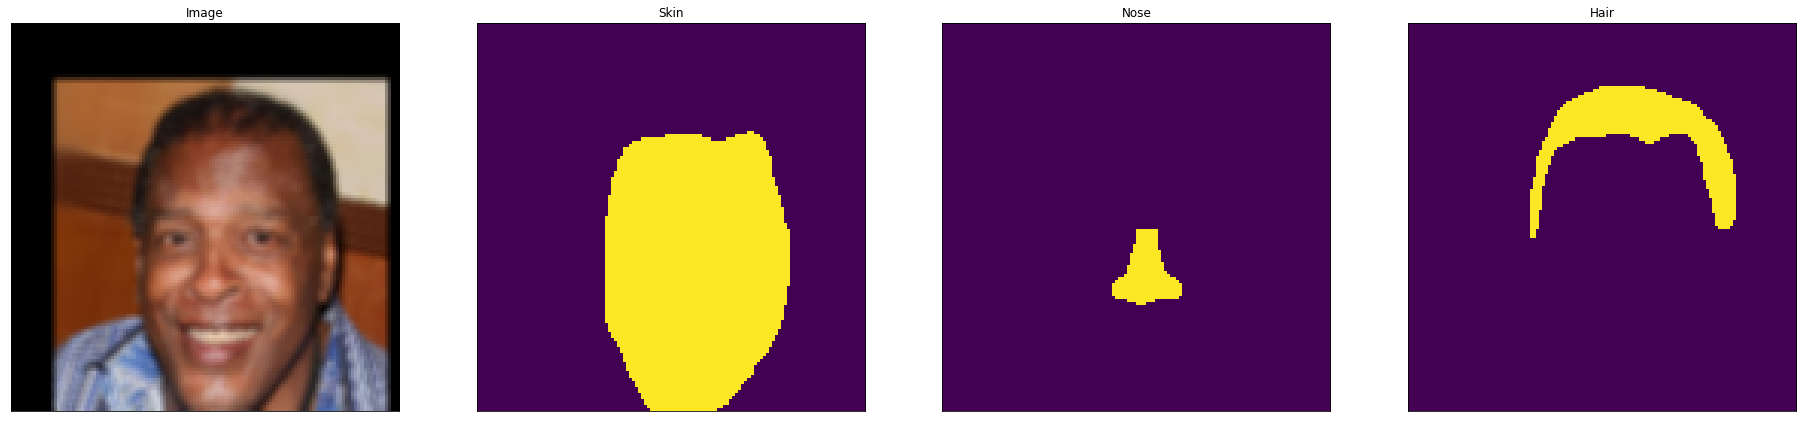

In [14]:
img_size = (128, 128)

# Lets look at augmented data we have
dataset = Dataset(X_train, y_train, classes=classes, augmentation=get_training_augmentation(img_size))

image, mask = dataset[48] # get some sample
visualize(
    image=image, 
    skin=mask[:, :, 0],
    nose=mask[:, :, 1],
    hair=mask[:, :, 12],
)

# Segmentation model training

In [62]:
import segmentation_models as sm
import tensorflow as tf

In [63]:
backbone = 'resnet50'
BATCH_SIZE = 8
CLASSES = classes
learning_rate = 1e-4
EPOCHS = 50
n_classes = 18

preprocess_input = sm.get_preprocessing(backbone)

In [69]:
train_dataset = Dataset(
    X_train, 
    y_train, 
    classes=CLASSES, 
    augmentation=None,
    preprocessing=get_preprocessing(preprocess_input),
)

valid_dataset = Dataset(
    X_val, 
    y_val, 
    classes=CLASSES, 
    augmentation=None,
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_ulan_bengio_resnet50.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

In [70]:
model = sm.Unet(backbone, classes=n_classes, activation="sigmoid", encoder_weights='imagenet', encoder_freeze=True)

In [71]:
optim = keras.optimizers.Adam(learning_rate)

dice_loss = sm.losses.DiceLoss(class_weights=1, smooth=0.1)

metrics = [sm.metrics.IOUScore(threshold=0.5)]

model.compile(optim, dice_loss, metrics)

In [72]:
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS,
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/50
400/400 [==============================] - 41s 93ms/step - loss: 0.8731 - iou_score: 0.1568 - val_loss: 0.8161 - val_iou_score: 0.3012 - lr: 1.0000e-04
Epoch 2/50
400/400 [==============================] - 37s 93ms/step - loss: 0.5948 - iou_score: 0.4243 - val_loss: 0.5648 - val_iou_score: 0.4966 - lr: 1.0000e-04
Epoch 3/50
400/400 [==============================] - 34s 84ms/step - loss: 0.4259 - iou_score: 0.5277 - val_loss: 0.4981 - val_iou_score: 0.5453 - lr: 1.0000e-04
Epoch 4/50
400/400 [==============================] - 33s 83ms/step - loss: 0.3706 - iou_score: 0.5724 - val_loss: 0.4767 - val_iou_score: 0.5632 - lr: 1.0000e-04
Epoch 5/50
400/400 [==============================] - 33s 83ms/step - loss: 0.3434 - iou_score: 0.5964 - val_loss: 0.4674 - val_iou_score: 0.5899 - lr: 1.0000e-04
Epoch 6/50
400/400 [==============================] - 34s 84ms/step - loss: 0.3206 - iou_score: 0.6198 - val_loss: 0.4550 - val_iou_score: 0.6413 - lr: 1.0000e-04
Epoch 7/50
400/400 [==

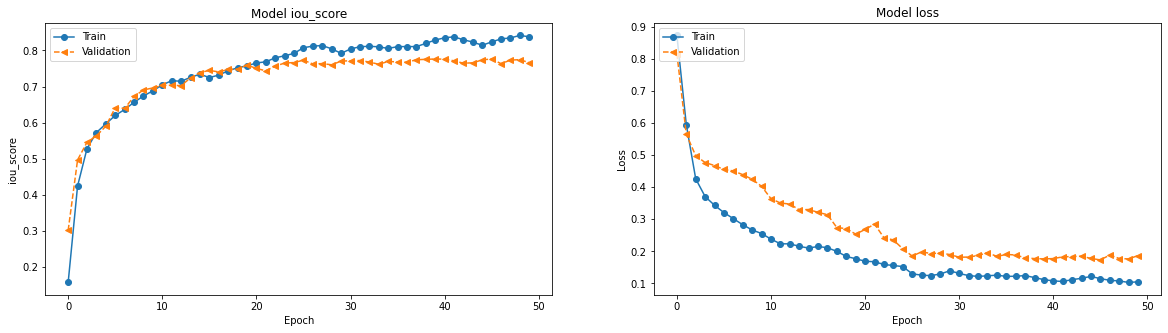

In [73]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'], '-o')
plt.plot(history.history['val_iou_score'], '--<')
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'], '-o')
plt.plot(history.history['val_loss'], '--<')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model Evaluation

In [172]:
test_dataset = Dataset(
    X_val, 
    y_val, 
    classes=CLASSES, 
    augmentation=None,
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [75]:
# Save a model
model.save('best_model_ulan_bengio_resnet50.h5')

In [74]:
import time

start_time = time.time()
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))
end_time = time.time() - start_time
print('runtime: ', end_time)

c:\Users\Lab311\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


Loss: 0.18672
mean iou_score: 0.76592
runtime:  12.850980281829834


# Visualization of results on test dataset

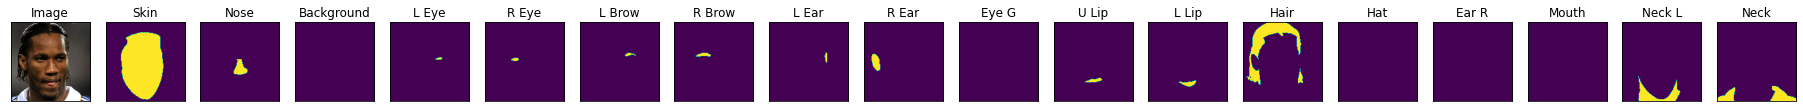

1/1 [==============================] - 0s 26ms/step
(128, 128, 18)


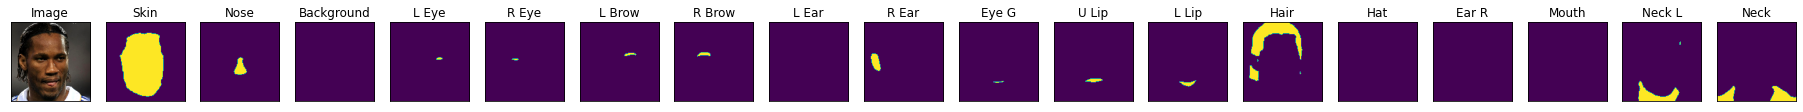

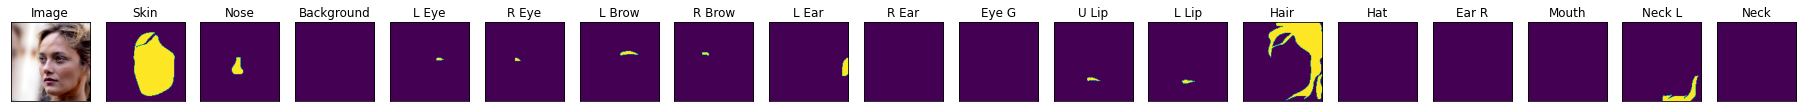

1/1 [==============================] - 0s 27ms/step
(128, 128, 18)


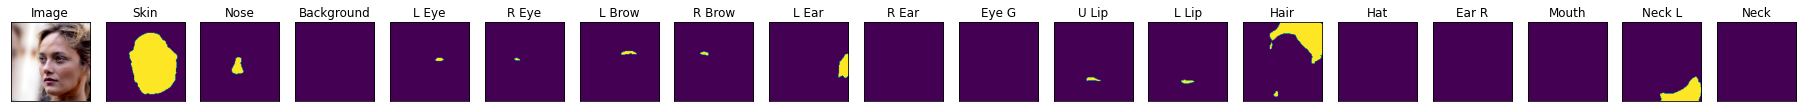

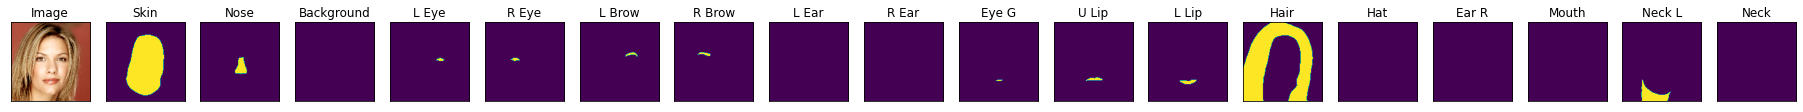

1/1 [==============================] - 0s 22ms/step
(128, 128, 18)


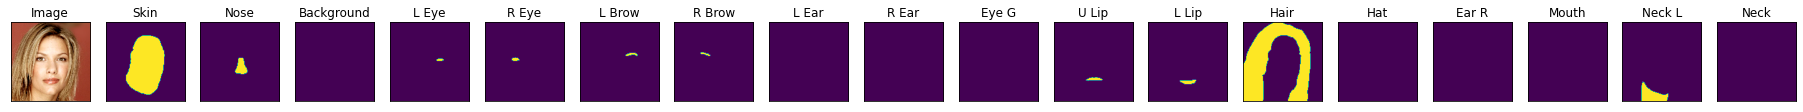

In [79]:
i = 0
for x, y in valid_dataloader:
    if i == 3: break
    IMAGE, MASK = x, y
    image, mask_true = IMAGE[0], MASK[0]


    visualize(
        image=image_denormalize(image), 
        skin=mask_true[:, :, 0],
        nose=mask_true[:, :, 1],
        background=mask_true[:, :, 2],
        l_eye=mask_true[:, :, 3],
        r_eye=mask_true[:, :, 4],
        l_brow=mask_true[:, :, 5],
        r_brow=mask_true[:, :, 6],
        l_ear=mask_true[:, :, 7],
        r_ear=mask_true[:, :, 8],
        eye_g=mask_true[:, :, 9],
        u_lip=mask_true[:, :, 10],
        l_lip=mask_true[:, :, 11],
        hair=mask_true[:, :, 12],
        hat=mask_true[:, :, 13],
        ear_r=mask_true[:, :, 14],
        mouth=mask_true[:, :, 15],
        neck_l=mask_true[:, :, 16],
        neck=mask_true[:, :, 17],
    )

    mask_pred = (model.predict(IMAGE).squeeze() > 0.5).astype(np.uint8)
    print(mask_pred.shape)

    visualize(
        image=image_denormalize(image),
        skin=mask_pred[:, :, 0],
        nose=mask_pred[:, :, 1],
        background=mask_pred[:, :, 2],
        l_eye=mask_pred[:, :, 3],
        r_eye=mask_pred[:, :, 4],
        l_brow=mask_pred[:, :, 5],
        r_brow=mask_pred[:, :, 6],
        l_ear=mask_pred[:, :, 7],
        r_ear=mask_pred[:, :, 8],
        eye_g=mask_pred[:, :, 9],
        u_lip=mask_pred[:, :, 10],
        l_lip=mask_pred[:, :, 11],
        hair=mask_pred[:, :, 12],
        hat=mask_pred[:, :, 13],
        ear_r=mask_pred[:, :, 14],
        mouth=mask_pred[:, :, 15],
        neck_l=mask_pred[:, :, 16],
        neck=mask_pred[:, :, 17],
    )
    i+=1

In [ ]:
import tensorflow as tf
from sklearn.metrics import jaccard_score
import onnx
import onnxruntime as ort
import tf2onnx

In [78]:
# Saving the onnx model

model_proto, external_tensor_storage = tf2onnx.convert.from_keras(model)
with open('resnet50_bengio_ulan.onnx', 'wb') as f:
    f.write(model_proto.SerializeToString())

In [92]:
import time
import onnx
import onnxruntime as ort
from sklearn.metrics import jaccard_score



onnx.checker.check_model(onnx.load('resnet50_bengio_ulan.onnx'))
ort_sess = ort.InferenceSession('resnet50_bengio_ulan.onnx')

input_name = ort_sess.get_inputs()[0].name
output_name = ort_sess.get_outputs()[0].name

# test_data = np.clip(128 + 50 *np.random.randn(16, 192, 384, 3), 0, 255).astype(np.float32) 
# test_labels = np.clip(128 + 50 *np.random.randn(16, 192, 384), 0, 255)/256

test_data = X_test.astype(np.float32)
test_labels = y_test

error = 0
batch_size = 8
start_time = time.time()
cnt = 0
res = []

while cnt*batch_size < len(test_data):
    onnx_out = np.squeeze(ort_sess.run(None, {input_name: test_data[cnt*batch_size:(cnt+1)*batch_size]}))
    res.append(onnx_out)
    cnt += 1
runtime = time.time() - start_time

for cnt, onnx_out in enumerate(res):
    for class_id in range(18):
        pred = onnx_out[:, :, :, class_id] >= 0.5
        error += jaccard_score(test_labels[cnt*batch_size:(cnt+1)*batch_size, :, :, class_id].ravel(), pred.ravel(), average='micro')
print(f'ONNX IoU = {error/(cnt+1)/18}, runtime = {runtime/(cnt+1)/batch_size}')

ONNX IoU = 0.9836632649219376, runtime = 0.020422764122486115
